In [1]:
import sys
sys.path.append("config")
# exec(f"from configs_default import config")
exec(f"from configs_debug import config")

In [2]:
config

{'num_train_timesteps': 1000,
 'num_inference_timesteps': 50,
 'prediction_type': 'v_prediction',
 'cfg_drop_prob': 0.25,
 'cfg_scale': 7.5,
 'cfg_rescale': 0.1,
 'train_text_clap_load_prob': 0.5,
 'train_dataset_size': 800,
 'train_batch_size': 16,
 'val_dataset_size': 4,
 'val_batch_size': 4,
 'ema_decay': 0.995,
 'learning_rate': 5e-05,
 'lr_warmup_steps': 100,
 'checkpoint_every': 400,
 'demo_every': 100,
 'max_epochs': 50,
 'train_primary_prob': 0.5,
 'load_audio_clap_prob': 0.5,
 'clap_cond_drop_prob': 0.5,
 't5_cond_drop_prob': 0.1,
 'key_cond_drop_prob': 0.4,
 'sample_size': 256,
 'in_channels_primary': 8,
 'in_channels_secondary': 72,
 'out_channels_primary': 8,
 'out_channels_secondary': 64,
 'down_block_types': ('CrossAttnDownBlock1D',
  'AttnDownBlock1D',
  'CrossAttnDownBlock1D',
  'ResnetDownsampleBlock1D'),
 'mid_block_type': 'UNetMidBlock1DCrossAttn',
 'up_block_types': ('ResnetUpsampleBlock1D',
  'CrossAttnUpBlock1D',
  'AttnUpBlock1D',
  'CrossAttnUpBlock1D'),
 'block

In [12]:
# TODO: 
# 0. re-test mnist_dpmsolver with additive class emb - done
# 1. implement vall-e pipeline - done
# 2. write the pl_module for training
# - in train.py, save the modified config (maybe modified through args like train_primary_prob) to the output dir; (let user specify config) - done
# - finish the train.py (instance creation, validation configs, wandb settings) - done
# - debug training loop and validation loop - done
# 3. run overfit test with debug config
# - debug sampling loop: write test script and load overfitted model

In [2]:
!python train.py \
-config-path config/configs_debug.py \
-trainset-dir data/example_h5_files \
-valset-dir data/example_h5_files \
--name 20241023_debug \
--num-gpus 1 \
--load-ckpt-path results/20241022_debug2/epoch=4991-step=249600.ckpt \
--wandb-key 2b65835eaa1c518d6810a245502bd7b55e7edbcc

- Running with config 
 {'num_train_timesteps': 1000, 'num_inference_timesteps': 50, 'prediction_type': 'v_prediction', 'cfg_drop_prob': 0.25, 'cfg_scale': 7.5, 'cfg_rescale': 0.1, 'train_text_clap_load_prob': 0.5, 'train_dataset_size': 800, 'train_batch_size': 4, 'val_dataset_size': 4, 'val_batch_size': 4, 'ema_decay': 0.995, 'learning_rate': 5e-05, 'lr_warmup_steps': 100, 'checkpoint_every': 400, 'demo_every': 100, 'max_epochs': 50, 'save_top_k': 5, 'train_primary_prob': 0.5, 'load_audio_clap_prob': 0.5, 'clap_cond_drop_prob': 0.5, 't5_cond_drop_prob': 0.1, 'key_cond_drop_prob': 0.4, 'sample_size': 256, 'in_channels_primary': 8, 'in_channels_secondary': 72, 'out_channels_primary': 8, 'out_channels_secondary': 64, 'down_block_types': ('CrossAttnDownBlock1D', 'AttnDownBlock1D', 'CrossAttnDownBlock1D', 'ResnetDownsampleBlock1D'), 'mid_block_type': 'UNetMidBlock1DCrossAttn', 'up_block_types': ('ResnetUpsampleBlock1D', 'CrossAttnUpBlock1D', 'AttnUpBlock1D', 'CrossAttnUpBlock1D'), 'block_o

In [ ]:
python train.py \
-config-path config/configs_debug.py \
-trainset-dir data/example_h5_files \
-valset-dir data/example_h5_files \
--name 20241021_debug \
--num-gpus 1 \
--wandb-key 2b65835eaa1c518d6810a245502bd7b55e7edbcc

In [1]:
import dac
import torch
import matplotlib.pyplot as plt

from data.h5_dataset import DacEncodecClapDatasetH5

h5_dir = "data/example_h5_files"
dac_frame_len = 256
dataset = DacEncodecClapDatasetH5(
    h5_dir=h5_dir,
    dac_frame_len=dac_frame_len,
)
chunk_data = dataset[0]
batch_dac_latents = torch.tensor(chunk_data["dac_latents"]).unsqueeze(0)#.to("cuda")

with torch.no_grad():
    dac_model_path = dac.utils.download(model_type="44khz")
    dac_model = dac.DAC.load(dac_model_path)#.to("cuda")
    z = dac_model.quantizer.from_latents(batch_dac_latents)[0] # [B, D, L]
    sampled_audios_reconstructed = dac_model.decode(z) # [B, T]



Reading dac h5 file metadata...
Num files: 7


    `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
    torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.


In [2]:
print(sampled_audios_reconstructed.shape)

torch.Size([1, 1, 131072])


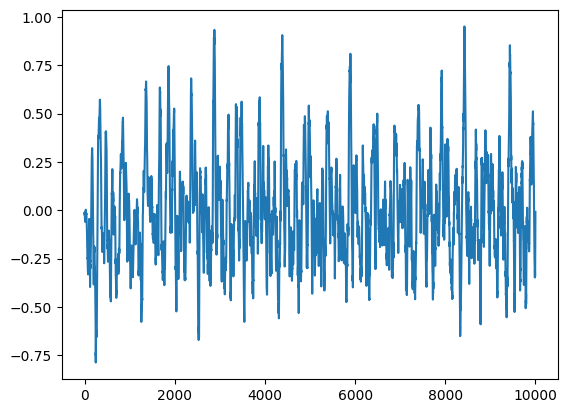

In [9]:
plt.plot(sampled_audios_reconstructed.squeeze(0).cpu().numpy()[0,:10000])